In [2]:
from sklearn.decomposition import PCA
def pca(df_X, df_y):
    pca = PCA(n_components = 2)
    pca.fit(df_X)
    df_pca = pca.transform(df_X)
    df_pca = pd.DataFrame(df_pca, columns = ['comp. 0', 'comp. 1'])
    df_pca['target'] = df_y
    print('variance ratio:', pca.explained_variance_ratio_, 'sum:', sum(pca.explained_variance_ratio_))
    return df_pca

def concath(df_X, df_y):
    df = pd.concat([df_X, df_y])
    return df

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from matplotlib import pyplot as plt
from sklearn import metrics
import tensorflow as tf
import keras
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras import optimizers
import math


################################ MSE ################################
def MSE(y_true, y_pred):
    return tf.reduce_mean(tf.math.square(y_true - y_pred))

################################ BCE ################################
import tensorflow as tf
def BCE(y_true, y_pred):
    return -tf.reduce_mean(y_true*tf.math.log(y_pred)+(1-y_true)*tf.math.log(1-y_pred))

################################ Ours_Accu ################################
def Ours_Accu(y_true, y_pred):
    y_pred = 1/(1+tf.math.exp(-L*(y_pred-0.5)))
    yl = y_train.shape[0]
    accu = (yl-tf.reduce_sum(y_true)-tf.reduce_sum(y_pred)+2*tf.reduce_sum(y_true*y_pred)) / yl
    return 1-accu

################################ Ours_Fbeta ################################
def Ours_Fbeta(y_true, y_pred):
#     beta = 1 
    y_pred = 1/(1+tf.math.exp(-L*(y_pred-0.5)))
    numerator = (1+beta**2)*tf.reduce_sum(y_true*y_pred)
    denominator = (beta**2)*tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return 1-(numerator/denominator)

################################ Ours_Gmean ################################
def Ours_Gmean(y_true, y_pred):
    y_pred = 1/(1+tf.math.exp(-L*(y_pred-0.5)))
    syhy = tf.reduce_sum(y_true*y_pred)
    sy = tf.reduce_sum(y_true)
    yl = (y_train.shape[0])
#     gmean = syhy*(yl-tf.reduce_sum(y_pred)-sy+syhy)/(sy*(yl-sy))
    gmean = tf.sqrt(syhy*(yl-tf.reduce_sum(y_pred)-sy+syhy)/(sy*(yl-sy)))
    return 1-gmean

################################ Ours_BAccu ################################
def Ours_BAccu(y_true, y_pred):
    y_pred = 1/(1+tf.math.exp(-L*(y_pred-0.5)))
    syhy = tf.reduce_sum(y_true*y_pred)
    sy = tf.reduce_sum(y_true)
    yl = y_train.shape[0]
    baccu = (yl*(syhy+sy)-sy*(tf.reduce_sum(y_pred)+sy)) / (2*sy*(yl-sy))
    return 1-baccu


# 1. My own data(2d / 10,000)

In [5]:
from sklearn import datasets
import numpy as np
import pandas as pd
Init_X, Init_y = datasets.make_classification(n_samples=10000, n_classes=2, weights=[0.9, 0.1], class_sep=1.2,
                                    n_features=5, n_informative=3, n_redundant=1, n_clusters_per_class=1, random_state=0)
X = np.array(Init_X)
y = np.array(Init_y)
# # change 0 -> -1
# y = [-1 if x==0 else x for x in y]

df_pca = pca(X, y)
df_pca

variance ratio: [0.42833444 0.25307059] sum: 0.681405030438325


,comp. 0,comp. 1,target
0,1.695416,1.809229,0
1,0.982001,-1.214855,0
2,-0.817025,0.504334,0
3,-0.235227,-0.039080,0
4,-0.534662,-2.206977,0
...,...,...,...
9995,-1.686589,1.869398,1
9996,-0.455202,0.290077,0
9997,-0.970592,-1.940881,0
9998,-2.826011,0.173755,0


In [6]:
L = 73
hidden_node = 2
# momentum=0.9
activation = 'sigmoid'  
kernel_initializer=keras.initializers.he_normal(seed=100)
epochs=50
threshold = 0.5

In [15]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state = 2)

fscore = []

X = df_pca.iloc[:, :2]
y = df_pca.iloc[:, 2]

for i in range(34):
    print('!'*50,'L={0}'.format(3*i+1),'!'*50)
    L = 3*i + 1
    f1 = []
    batch_size = int(X.shape[0]*0.9 * 0.05)  
    learning_rate = 0.001
    model = Sequential()
    model.add(Dense(hidden_node, input_dim=X.shape[1], kernel_initializer=kernel_initializer))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dense(1))
    opt = optimizers.Adam(learning_rate = learning_rate)   # SGD(learning_rate=learning_rate, momentum=momentum)
    
    n_iter=0
    for train_index, test_index in skf.split(X, y):
        n_iter += 1
        X_train = X.iloc[train_index]
        y_train= y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test= y.iloc[test_index]
    #     print('#'*50,'{0}th CV'.format(n_iter),'#'*50)
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        y_train = y_train.astype(float)
        X_test = np.array(X_test)
        y_test = np.array(y_test)
        y_test = y_test.astype(float)

        ###################### Ours(F1) ##############################  
        beta = 1
        model.compile(loss=Ours_Fbeta, optimizer=opt, metrics=['accuracy'])
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0, batch_size=batch_size)
#         plt.plot(history.history['loss'], label='loss')
#         plt.ylim([0, 1])
#         plt.xlabel('Iteration',fontweight="bold",fontsize = 15)
#         plt.ylabel('Loss',fontweight="bold",fontsize = 15)
#         plt.title("Cost Function",fontweight="bold",fontsize = 20)
#         plt.legend()
#         plt.show()
        predicted = []
        result = model.predict(X_test)
        for i in range(X_test.shape[0]):
            if result[i] <= threshold:
                predicted.append(0)
            else:
                predicted.append(1)
        TN = metrics.confusion_matrix(y_test, predicted)[0,0]
        FP = metrics.confusion_matrix(y_test, predicted)[0,1]
        FN = metrics.confusion_matrix(y_test, predicted)[1,0]
        TP = metrics.confusion_matrix(y_test, predicted)[1,1]
        f1.append(TP / (TP + 0.5*(FP+FN)))

    print('F1 =', np.mean(f1), f1)
    fscore.append(np.mean(f1))

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! L=1 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
63/63 [==============================] - 0s 444us/step
F1 = 0.5769246635244245 [0.3769968051118211, 0.6109979633401222, 0.6626984126984127, 0.6081632653061224, 0.6257668711656442]
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! L=4 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
63/63 [==============================] - 0s 471us/step
F1 = 0.6118154543191244 [0.5468354430379747, 0.5855855855855856, 0.6832298136645962, 0.6228813559322034, 0.6205450733752621]
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! L=7 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
63/63 [==============================] - 0s 434us/step
F1 = 0.6361431097771063 [0.6293436293436293, 0.6205450733752621, 0.6805845511482255, 0.6233766233766234, 0.6268656716417911]
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! L=10 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
63/63 [============================

63/63 [==============================] - 0s 441us/step
F1 = 0.6294252739834223 [0.5888077858880778, 0.6100917431192661, 0.6857142857142857, 0.6385809312638581, 0.6239316239316239]
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! L=52 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
63/63 [==============================] - 0s 457us/step
F1 = 0.0 [0.0, 0.0, 0.0, 0.0, 0.0]
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! L=55 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
63/63 [==============================] - 0s 454us/step
F1 = 0.1895536359893402 [0.1892258940697148, 0.1892258940697148, 0.1892258940697148, 0.19004524886877827, 0.19004524886877827]
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! L=58 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
63/63 [==============================] - 0s 453us/step
F1 = 0.600884927247948 [0.47645429362880887, 0.5882352941176471, 0.6885964912280702, 0.62882096069869, 0.6223175965665236]
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

63/63 [==============================] - 0s 472us/step
F1 = 0.6245130548386346 [0.5812356979405034, 0.6064814814814815, 0.6795698924731183, 0.6313465783664459, 0.6239316239316239]
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! L=100 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
63/63 [==============================] - 0s 454us/step
F1 = 0.1895536359893402 [0.1892258940697148, 0.1892258940697148, 0.1892258940697148, 0.19004524886877827, 0.19004524886877827]


In [16]:
df_f = pd.DataFrame({'L':list(np.arange(1, 101, 3)), 'fscore':fscore})
df_f

,L,fscore
0,1,0.576925
1,4,0.611815
2,7,0.636143
3,10,0.637206
4,13,0.633530
5,16,0.633805
6,19,0.631071
7,22,0.629297
8,25,0.636869
9,28,0.633046


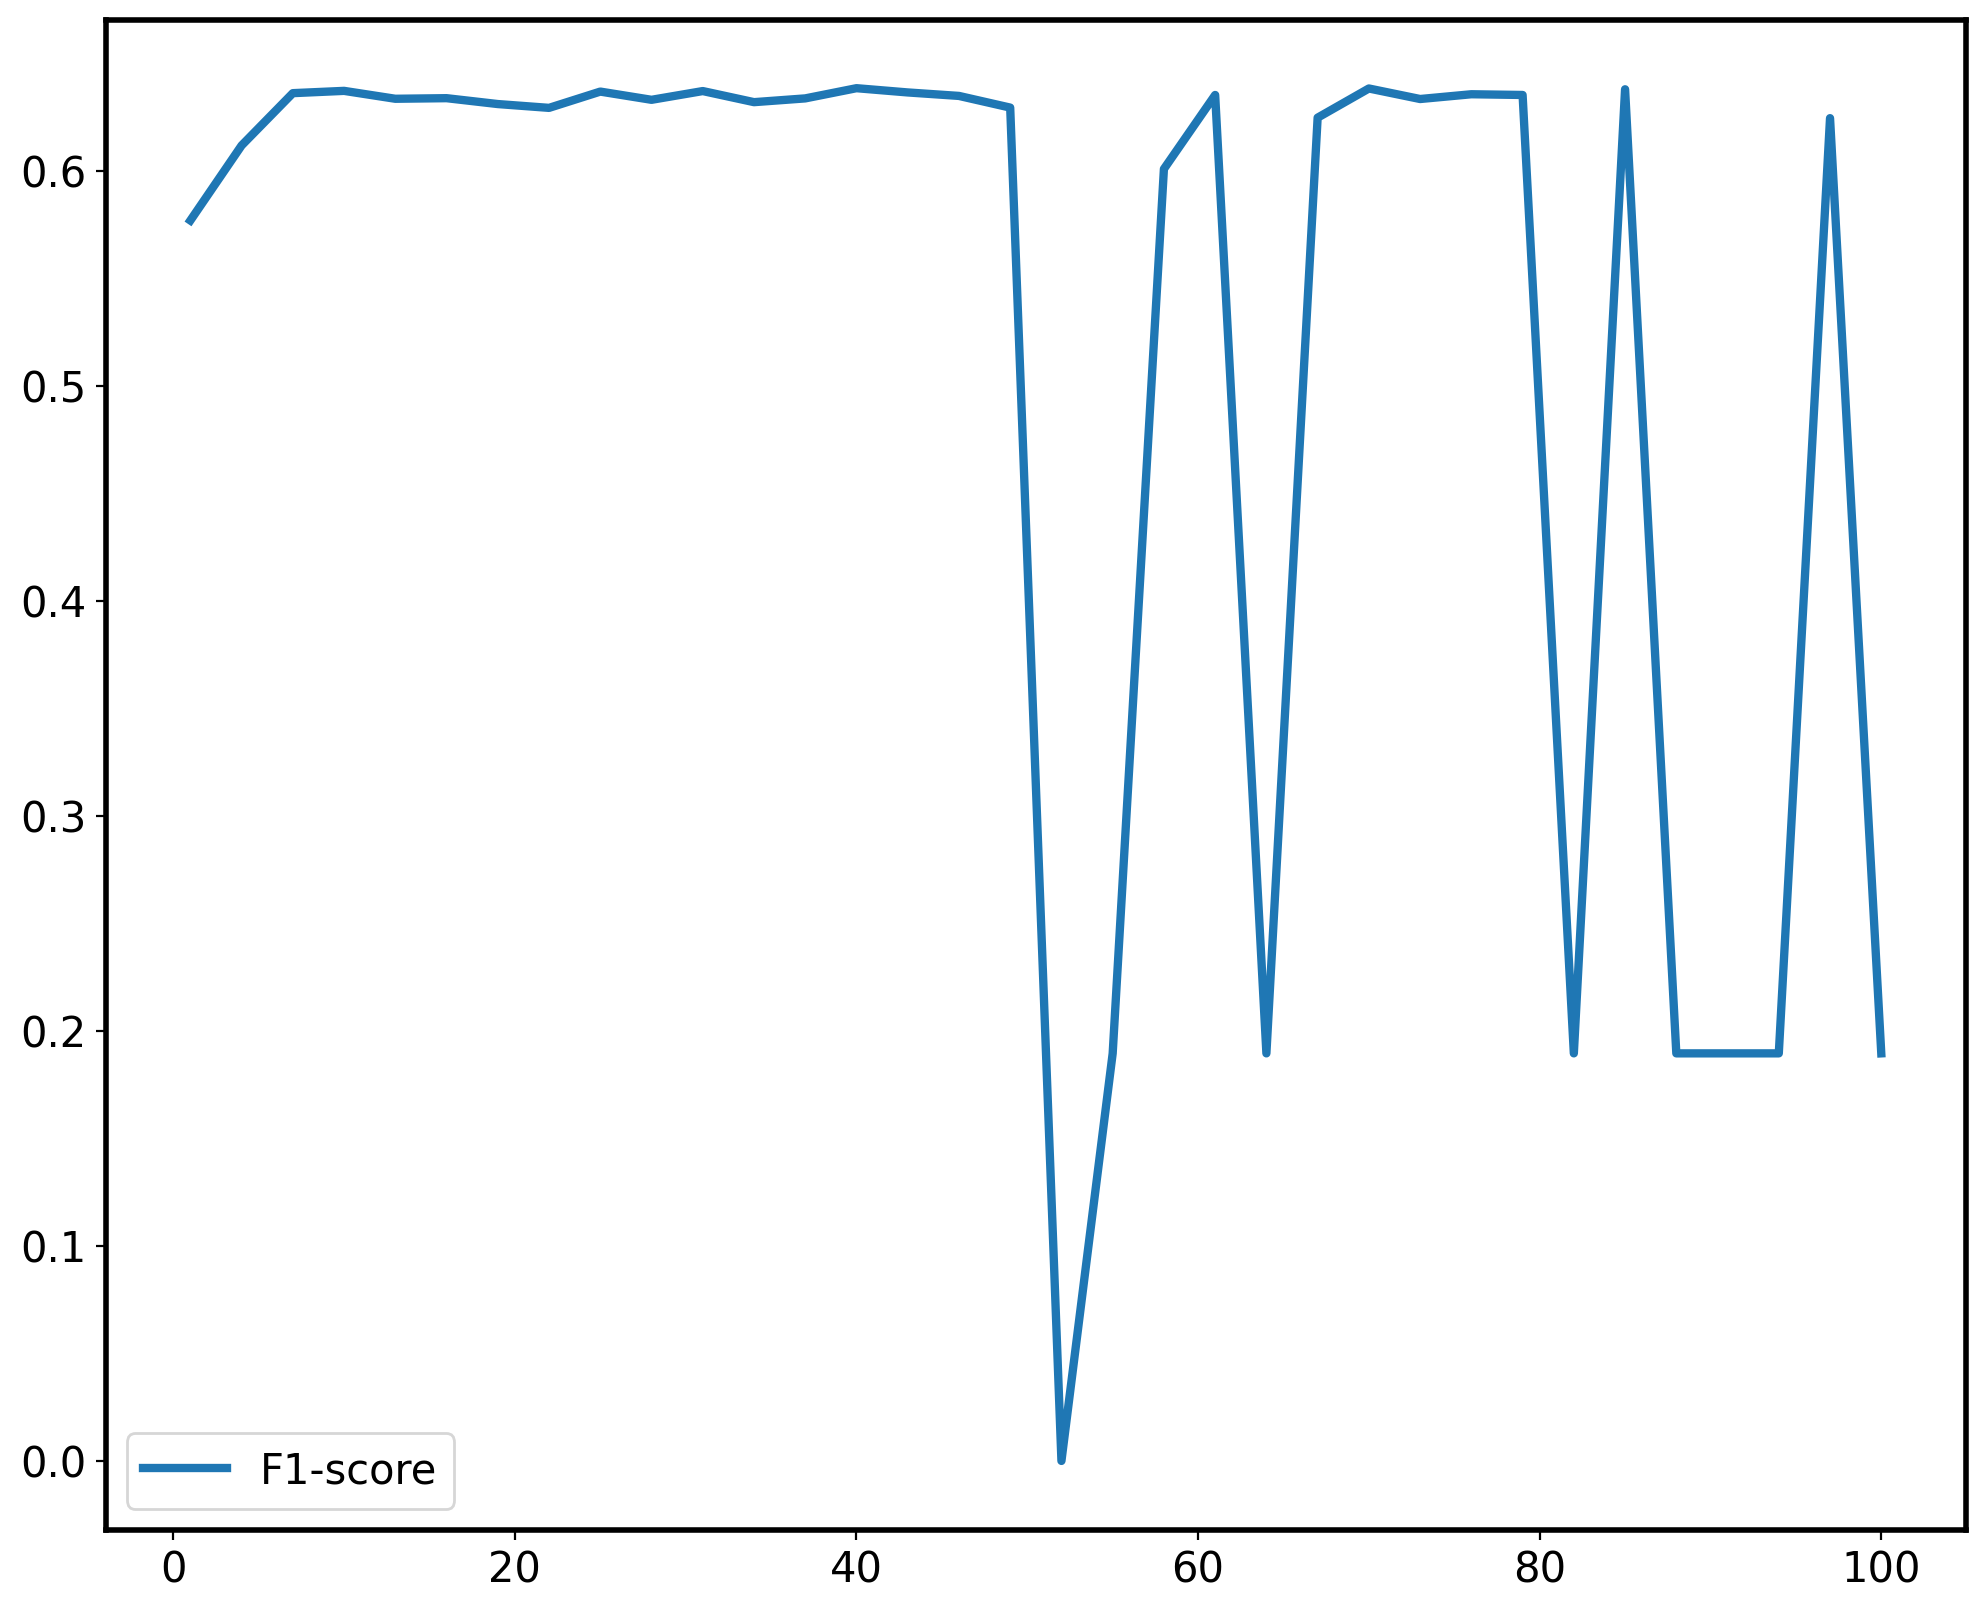

In [17]:
x = df_f['L']
y = df_f['fscore']

plt.figure(figsize=(12,10))
plt.plot(x,y,linewidth=3, label = 'F1-score')

# plt.ylim(0.0,0.6) # y축 값의 범위 설정
plt.legend()
plt.show()

In [18]:
df_f.to_csv("5CV_MLP_Random_L.csv", float_format='%.4g')

In [19]:
df = pd.read_csv("5CV_MLP_Random_L.csv")
df

,Unnamed: 0,L,fscore
0,0,1,0.5769
1,1,4,0.6118
2,2,7,0.6361
3,3,10,0.6372
4,4,13,0.6335
5,5,16,0.6338
6,6,19,0.6311
7,7,22,0.6293
8,8,25,0.6369
9,9,28,0.6330


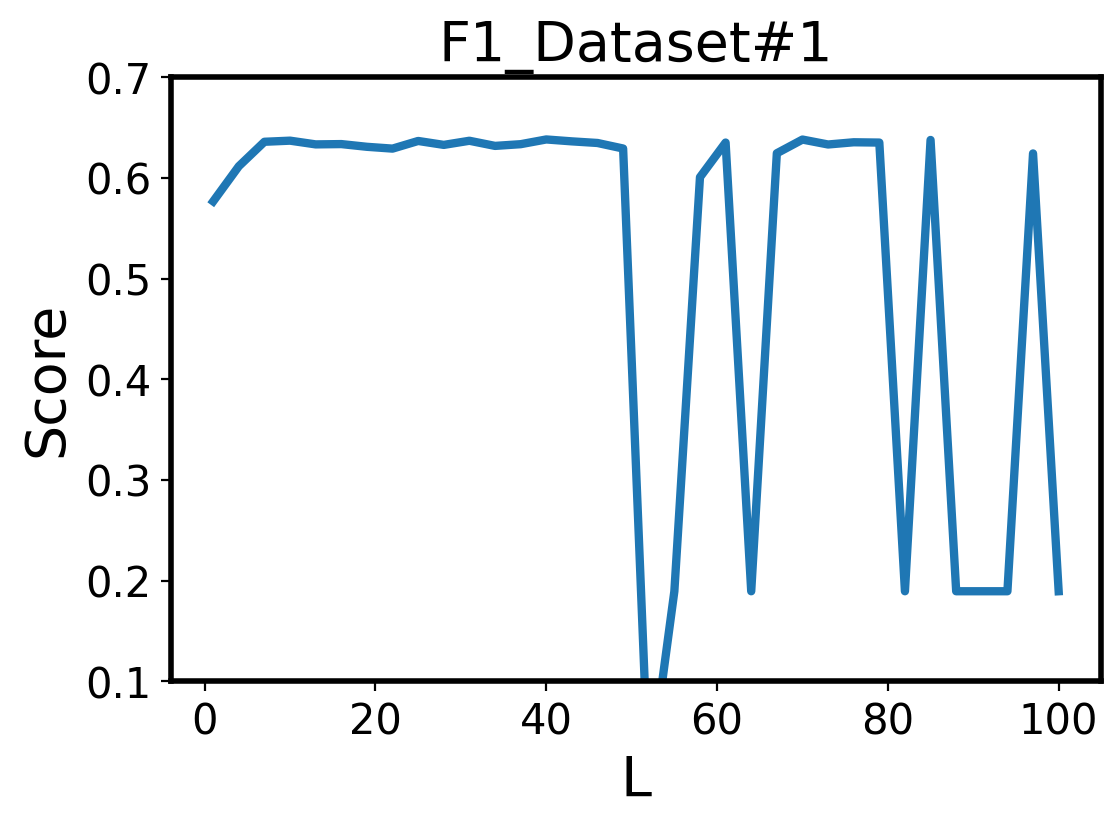

In [20]:
# plt.rcParams["figure.figsize"] = [5, 3]
plt.rcParams["figure.dpi"] = 200
plt.rcParams['axes.titlesize'] = 20  
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.labelsize'] = 20  
plt.rcParams['font.size'] = 15

x = df['L']
y = df['fscore']

plt.plot(x,y,linewidth=3, label = 'F1-score')

plt.ylim(0.1,0.7) # y축 값의 범위 설정
plt.xlabel('L',fontsize = 20)
plt.ylabel('Score',fontsize = 20)
plt.title("F1_Dataset#1",fontsize = 20)
# plt.legend()
plt.show()

# 2. Creditcard Fraud Detection 2023(29d / 298531)

In [21]:
# class '0' = normal, class '1' = anomaly
card_df = pd.read_csv('creditcard_2023.csv')
card_df.shape

(568630, 31)

In [22]:
# 결측치 확인
card_df.isnull().sum()

id        0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [23]:
card_df.head()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0


In [24]:
card_df.describe()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,568630.000000,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,...,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,568630.000000,568630.0
mean,284314.500000,-5.638058e-17,-1.319545e-16,-3.518788e-17,-2.879008e-17,7.997245e-18,-3.958636e-17,-3.198898e-17,2.109273e-17,3.998623e-17,...,4.758361e-17,3.948640e-18,6.194741e-18,-2.799036e-18,-3.178905e-17,-7.497417e-18,-3.598760e-17,2.609101e-17,12041.957635,0.5
std,164149.486122,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,6919.644449,0.5
min,0.000000,-3.495584e+00,-4.996657e+01,-3.183760e+00,-4.951222e+00,-9.952786e+00,-2.111111e+01,-4.351839e+00,-1.075634e+01,-3.751919e+00,...,-1.938252e+01,-7.734798e+00,-3.029545e+01,-4.067968e+00,-1.361263e+01,-8.226969e+00,-1.049863e+01,-3.903524e+01,50.010000,0.0
25%,142157.250000,-5.652859e-01,-4.866777e-01,-6.492987e-01,-6.560203e-01,-2.934955e-01,-4.458712e-01,-2.835329e-01,-1.922572e-01,-5.687446e-01,...,-1.664408e-01,-4.904892e-01,-2.376289e-01,-6.515801e-01,-5.541485e-01,-6.318948e-01,-3.049607e-01,-2.318783e-01,6054.892500,0.0
50%,284314.500000,-9.363846e-02,-1.358939e-01,3.528579e-04,-7.376152e-02,8.108788e-02,7.871758e-02,2.333659e-01,-1.145242e-01,9.252647e-02,...,-3.743065e-02,-2.732881e-02,-5.968903e-02,1.590123e-02,-8.193162e-03,-1.189208e-02,-1.729111e-01,-1.392973e-02,12030.150000,0.5
75%,426471.750000,8.326582e-01,3.435552e-01,6.285380e-01,7.070047e-01,4.397368e-01,4.977881e-01,5.259548e-01,4.729905e-02,5.592621e-01,...,1.479787e-01,4.638817e-01,1.557153e-01,7.007374e-01,5.500147e-01,6.728879e-01,3.340230e-01,4.095903e-01,18036.330000,1.0
max,568629.000000,2.229046e+00,4.361865e+00,1.412583e+01,3.201536e+00,4.271689e+01,2.616840e+01,2.178730e+02,5.958040e+00,2.027006e+01,...,8.087080e+00,1.263251e+01,3.170763e+01,1.296564e+01,1.462151e+01,5.623285e+00,1.132311e+02,7.725594e+01,24039.930000,1.0


In [25]:
# Amount values largely varies.

# # Normalization
# card_df.iloc[:,:-1] = (card_df.iloc[:,:-1] - card_df.iloc[:,:-1].min())/(card_df.iloc[:,:-1].max() - card_df.iloc[:,:-1].min())

# Standardization
card_df.iloc[:,:-1] = (card_df.iloc[:,:-1] - card_df.iloc[:,:-1].mean())/card_df.iloc[:,:-1].std()

card_df

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.732046,-0.260648,-0.469648,2.496264,-0.083724,0.129681,0.732898,0.519013,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,0.858446,0
1,-1.732040,0.985099,-0.356045,0.558056,-0.429654,0.277140,0.428604,0.406466,-0.133118,0.347452,...,-0.194936,-0.605760,0.079469,-0.577394,0.190090,0.296502,-0.248052,-0.064512,-0.796369,0
2,-1.732034,-0.260271,-0.949384,1.728536,-0.457986,0.074062,1.419480,0.743510,-0.095576,-0.261296,...,-0.005020,0.702906,0.945045,-1.154665,-0.605563,-0.312894,-0.300258,-0.244718,-1.377010,0
3,-1.732028,-0.152152,-0.508958,1.746839,-1.090177,0.249486,1.143311,0.518268,-0.065130,-0.205697,...,-0.146927,-0.038212,-0.214048,-1.893129,1.003962,-0.515950,-0.165316,0.048424,-0.962118,0
4,-1.732022,-0.206819,-0.165280,1.527051,-0.448292,0.106125,0.530548,0.658849,-0.212660,1.049920,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071125,0.023712,0.419117,0.323284,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568625,1.732022,-0.833437,0.061886,-0.899793,0.904226,-1.002400,0.481453,-0.370393,0.189693,-0.938152,...,0.167503,0.419731,1.288248,-0.900860,0.560661,-0.006018,3.308965,0.081564,-1.105230,1
568626,1.732028,-0.670459,-0.202896,-0.068129,-0.267328,-0.133660,0.237148,-0.016935,-0.147733,0.483893,...,0.031874,0.388161,-0.154257,-0.846451,-0.153443,1.961396,-1.528640,1.704305,-1.067766,1
568627,1.732034,-0.311997,-0.004095,0.137525,-0.035893,-0.042291,0.121098,-0.070958,-0.019997,-0.122048,...,0.140787,0.536522,-0.211100,-0.448908,0.540073,-0.755835,-0.487539,-0.268741,1.666400,1
568628,1.732040,0.636870,-0.516969,-0.300888,-0.144480,0.131042,-0.294148,0.580568,-0.207723,0.893526,...,-0.060380,-0.195609,-0.175487,-0.554643,-0.099669,-1.434930,-0.159269,-0.076251,-0.271853,1


In [26]:
card_df['Class'].value_counts()

0    284315
1    284315
Name: Class, dtype: int64

In [27]:
# Data is too balanced!!! We intentionally make it imbalanced.
df_0 = card_df[card_df['Class']==0]
df_1 = card_df[card_df['Class']==1]
print(len(df_0), len(df_1))

284315 284315


In [28]:
N = round(len(df_0)*0.05)
df_1_samp = df_1.sample(n=N, random_state = 100)
df_1_samp

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
506274,1.352179,-0.006870,-0.167584,-0.426402,0.286979,3.061201,-1.574602,0.044742,-0.428210,0.154000,...,-0.386374,-0.470302,-1.743519,-1.185101,-1.558751,-1.397993,-0.012629,0.450646,1.114237,1
387527,0.628771,-1.505330,0.343708,-1.307073,1.727683,-0.524436,-2.021618,-2.304781,-0.078004,-1.148383,...,-0.427704,-1.212065,-12.554995,0.951595,-5.763942,0.191730,3.949965,-1.475321,-0.071128,1
365951,0.497330,-0.503065,0.153162,-0.422713,-0.354370,-0.419048,-0.107715,0.314880,-0.203583,0.279555,...,0.037084,-0.209385,0.549983,0.396777,-1.430279,-2.486924,-0.617871,0.560011,-1.321357,1
525848,1.471424,-1.021538,-1.187974,-0.746483,-0.029644,0.009252,-0.507414,0.471536,-0.015704,-0.207999,...,0.018479,0.766577,0.123668,0.268437,0.800809,0.413684,-0.034178,-0.097596,1.445303,1
481288,1.199964,-0.509792,0.194382,-0.386280,-0.611187,0.135320,0.440036,-0.240672,-0.615084,0.251804,...,-0.095779,0.402399,-0.251087,-0.566821,0.409498,-1.473372,-0.251349,-0.044765,-0.010947,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491209,1.260403,-1.088031,0.682312,-0.917454,0.643955,-0.652642,-0.555339,-0.667876,0.288458,-0.764149,...,0.528281,0.386071,0.095967,1.123651,-0.015030,0.636864,-1.803348,1.164825,-0.080206,1
372018,0.534290,-2.281503,2.701140,-2.214454,1.222394,-2.728423,-2.561828,-2.136703,4.308934,-1.151728,...,0.558177,-1.432524,-0.994643,0.310707,2.660860,-0.516013,1.909650,0.968061,0.731649,1
343903,0.363014,-0.267325,0.352643,-0.836113,0.475835,-0.673489,-0.723249,-0.492036,0.200382,-0.714633,...,0.283521,0.720715,0.230679,0.010768,-0.039101,1.150750,0.024092,-0.461128,0.646750,1
452083,1.022047,-2.174120,2.531664,-2.126482,1.202406,-2.566989,-2.477827,-2.045211,3.892891,-1.178189,...,0.554093,-1.297113,-0.862695,0.284146,2.371527,-0.520116,2.028946,1.024555,0.740116,1


In [29]:
df_card = concath(df_0, df_1_samp)
df_card

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.732046,-0.260648,-0.469648,2.496264,-0.083724,0.129681,0.732898,0.519013,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,0.858446,0
1,-1.732040,0.985099,-0.356045,0.558056,-0.429654,0.277140,0.428604,0.406466,-0.133118,0.347452,...,-0.194936,-0.605760,0.079469,-0.577394,0.190090,0.296502,-0.248052,-0.064512,-0.796369,0
2,-1.732034,-0.260271,-0.949384,1.728536,-0.457986,0.074062,1.419480,0.743510,-0.095576,-0.261296,...,-0.005020,0.702906,0.945045,-1.154665,-0.605563,-0.312894,-0.300258,-0.244718,-1.377010,0
3,-1.732028,-0.152152,-0.508958,1.746839,-1.090177,0.249486,1.143311,0.518268,-0.065130,-0.205697,...,-0.146927,-0.038212,-0.214048,-1.893129,1.003962,-0.515950,-0.165316,0.048424,-0.962118,0
4,-1.732022,-0.206819,-0.165280,1.527051,-0.448292,0.106125,0.530548,0.658849,-0.212660,1.049920,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071125,0.023712,0.419117,0.323284,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491209,1.260403,-1.088031,0.682312,-0.917454,0.643955,-0.652642,-0.555339,-0.667876,0.288458,-0.764149,...,0.528281,0.386071,0.095967,1.123651,-0.015030,0.636864,-1.803348,1.164825,-0.080206,1
372018,0.534290,-2.281503,2.701140,-2.214454,1.222394,-2.728423,-2.561828,-2.136703,4.308934,-1.151728,...,0.558177,-1.432524,-0.994643,0.310707,2.660860,-0.516013,1.909650,0.968061,0.731649,1
343903,0.363014,-0.267325,0.352643,-0.836113,0.475835,-0.673489,-0.723249,-0.492036,0.200382,-0.714633,...,0.283521,0.720715,0.230679,0.010768,-0.039101,1.150750,0.024092,-0.461128,0.646750,1
452083,1.022047,-2.174120,2.531664,-2.126482,1.202406,-2.566989,-2.477827,-2.045211,3.892891,-1.178189,...,0.554093,-1.297113,-0.862695,0.284146,2.371527,-0.520116,2.028946,1.024555,0.740116,1


In [30]:
df_card.columns

Index(['id', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [31]:
df_card = df_card.drop('id', axis=1)
df_card

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.260648,-0.469648,2.496264,-0.083724,0.129681,0.732898,0.519013,-0.130006,0.727159,0.637734,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,0.858446,0
1,0.985099,-0.356045,0.558056,-0.429654,0.277140,0.428604,0.406466,-0.133118,0.347452,0.529808,...,-0.194936,-0.605760,0.079469,-0.577394,0.190090,0.296502,-0.248052,-0.064512,-0.796369,0
2,-0.260271,-0.949384,1.728536,-0.457986,0.074062,1.419480,0.743510,-0.095576,-0.261296,0.690707,...,-0.005020,0.702906,0.945045,-1.154665,-0.605563,-0.312894,-0.300258,-0.244718,-1.377010,0
3,-0.152152,-0.508958,1.746839,-1.090177,0.249486,1.143311,0.518268,-0.065130,-0.205697,0.575230,...,-0.146927,-0.038212,-0.214048,-1.893129,1.003962,-0.515950,-0.165316,0.048424,-0.962118,0
4,-0.206819,-0.165280,1.527051,-0.448292,0.106125,0.530548,0.658849,-0.212660,1.049920,0.968045,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071125,0.023712,0.419117,0.323284,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491209,-1.088031,0.682312,-0.917454,0.643955,-0.652642,-0.555339,-0.667876,0.288458,-0.764149,-0.665831,...,0.528281,0.386071,0.095967,1.123651,-0.015030,0.636864,-1.803348,1.164825,-0.080206,1
372018,-2.281503,2.701140,-2.214454,1.222394,-2.728423,-2.561828,-2.136703,4.308934,-1.151728,-1.283930,...,0.558177,-1.432524,-0.994643,0.310707,2.660860,-0.516013,1.909650,0.968061,0.731649,1
343903,-0.267325,0.352643,-0.836113,0.475835,-0.673489,-0.723249,-0.492036,0.200382,-0.714633,-0.660779,...,0.283521,0.720715,0.230679,0.010768,-0.039101,1.150750,0.024092,-0.461128,0.646750,1
452083,-2.174120,2.531664,-2.126482,1.202406,-2.566989,-2.477827,-2.045211,3.892891,-1.178189,-1.315622,...,0.554093,-1.297113,-0.862695,0.284146,2.371527,-0.520116,2.028946,1.024555,0.740116,1


In [32]:
L = 73
hidden_node = 2
# momentum=0.9
activation = 'sigmoid'  
kernel_initializer=keras.initializers.he_normal(seed=100)
epochs=50
threshold = 0.5

In [33]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state = 2)

fscore = []

X = df_card.iloc[:, :-1]
y = df_card.iloc[:, -1]

for i in range(34):
    print('!'*50,'L={0}'.format(3*i+1),'!'*50)
    L = 3*i + 1
    f1 = []
    batch_size = int(X.shape[0]*0.9 * 0.05)  
    learning_rate = 0.005
    model = Sequential()
    model.add(Dense(hidden_node, input_dim=X.shape[1], kernel_initializer=kernel_initializer))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dense(1))
    opt = optimizers.Adam(learning_rate = learning_rate)   # SGD(learning_rate=learning_rate, momentum=momentum)
    
    n_iter=0
    for train_index, test_index in skf.split(X, y):
        n_iter += 1
        X_train = X.iloc[train_index]
        y_train= y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test= y.iloc[test_index]
    #     print('#'*50,'{0}th CV'.format(n_iter),'#'*50)
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        y_train = y_train.astype(float)
        X_test = np.array(X_test)
        y_test = np.array(y_test)
        y_test = y_test.astype(float)

        ###################### Ours(F1) ##############################  
        beta = 1
        model.compile(loss=Ours_Fbeta, optimizer=opt, metrics=['accuracy'])
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0, batch_size=batch_size)
#         plt.plot(history.history['loss'], label='loss')
#         plt.ylim([0, 1])
#         plt.xlabel('Iteration',fontweight="bold",fontsize = 15)
#         plt.ylabel('Loss',fontweight="bold",fontsize = 15)
#         plt.title("Cost Function",fontweight="bold",fontsize = 20)
#         plt.legend()
#         plt.show()
        predicted = []
        result = model.predict(X_test)
        for i in range(X_test.shape[0]):
            if result[i] <= threshold:
                predicted.append(0)
            else:
                predicted.append(1)
        TN = metrics.confusion_matrix(y_test, predicted)[0,0]
        FP = metrics.confusion_matrix(y_test, predicted)[0,1]
        FN = metrics.confusion_matrix(y_test, predicted)[1,0]
        TP = metrics.confusion_matrix(y_test, predicted)[1,1]
        f1.append(TP / (TP + 0.5*(FP+FN)))

    print('F1 =', np.mean(f1), f1)
    fscore.append(np.mean(f1))

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! L=1 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
1866/1866 [==============================] - 1s 445us/step
F1 = 0.9320170859643799 [0.9362880886426593, 0.9269102990033222, 0.9298537849342957, 0.9357156013998895, 0.931317655841732]
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! L=4 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
1866/1866 [==============================] - 1s 431us/step
F1 = 0.922731704266781 [0.9130020940415001, 0.9088829584445292, 0.9146641438032167, 0.933852140077821, 0.9432571849668386]
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! L=7 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
1866/1866 [==============================] - 1s 435us/step
F1 = 0.9239142293512032 [0.91324200913242, 0.9081535230093565, 0.9213188460097415, 0.936657433056325, 0.9401993355481728]
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! L=10 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
1866/1866 [==================

1866/1866 [==============================] - 1s 434us/step
F1 = 0.7695944929784534 [0.9304412864622289, 0.937039764359352, 0.9395775941230486, 0.9500090892564989, 0.09090473069113815]
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! L=97 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
1866/1866 [==============================] - 1s 414us/step
F1 = 0.09091054415707352 [0.09093379802081501, 0.09090473069113815, 0.09090473069113815, 0.09090473069113815, 0.09090473069113815]
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! L=100 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
1866/1866 [==============================] - 1s 427us/step
F1 = 0.4200729116380758 [0.9125880784612455, 0.9150622876557192, 0.09090473069113815, 0.09090473069113815, 0.09090473069113815]


In [34]:
df_f = pd.DataFrame({'L':list(np.arange(1, 101, 3)), 'fscore':fscore})
df_f

,L,fscore
0,1,0.932017
1,4,0.922732
2,7,0.923914
3,10,0.926283
4,13,0.927777
5,16,0.928506
6,19,0.945923
7,22,0.935528
8,25,0.934341
9,28,0.932071


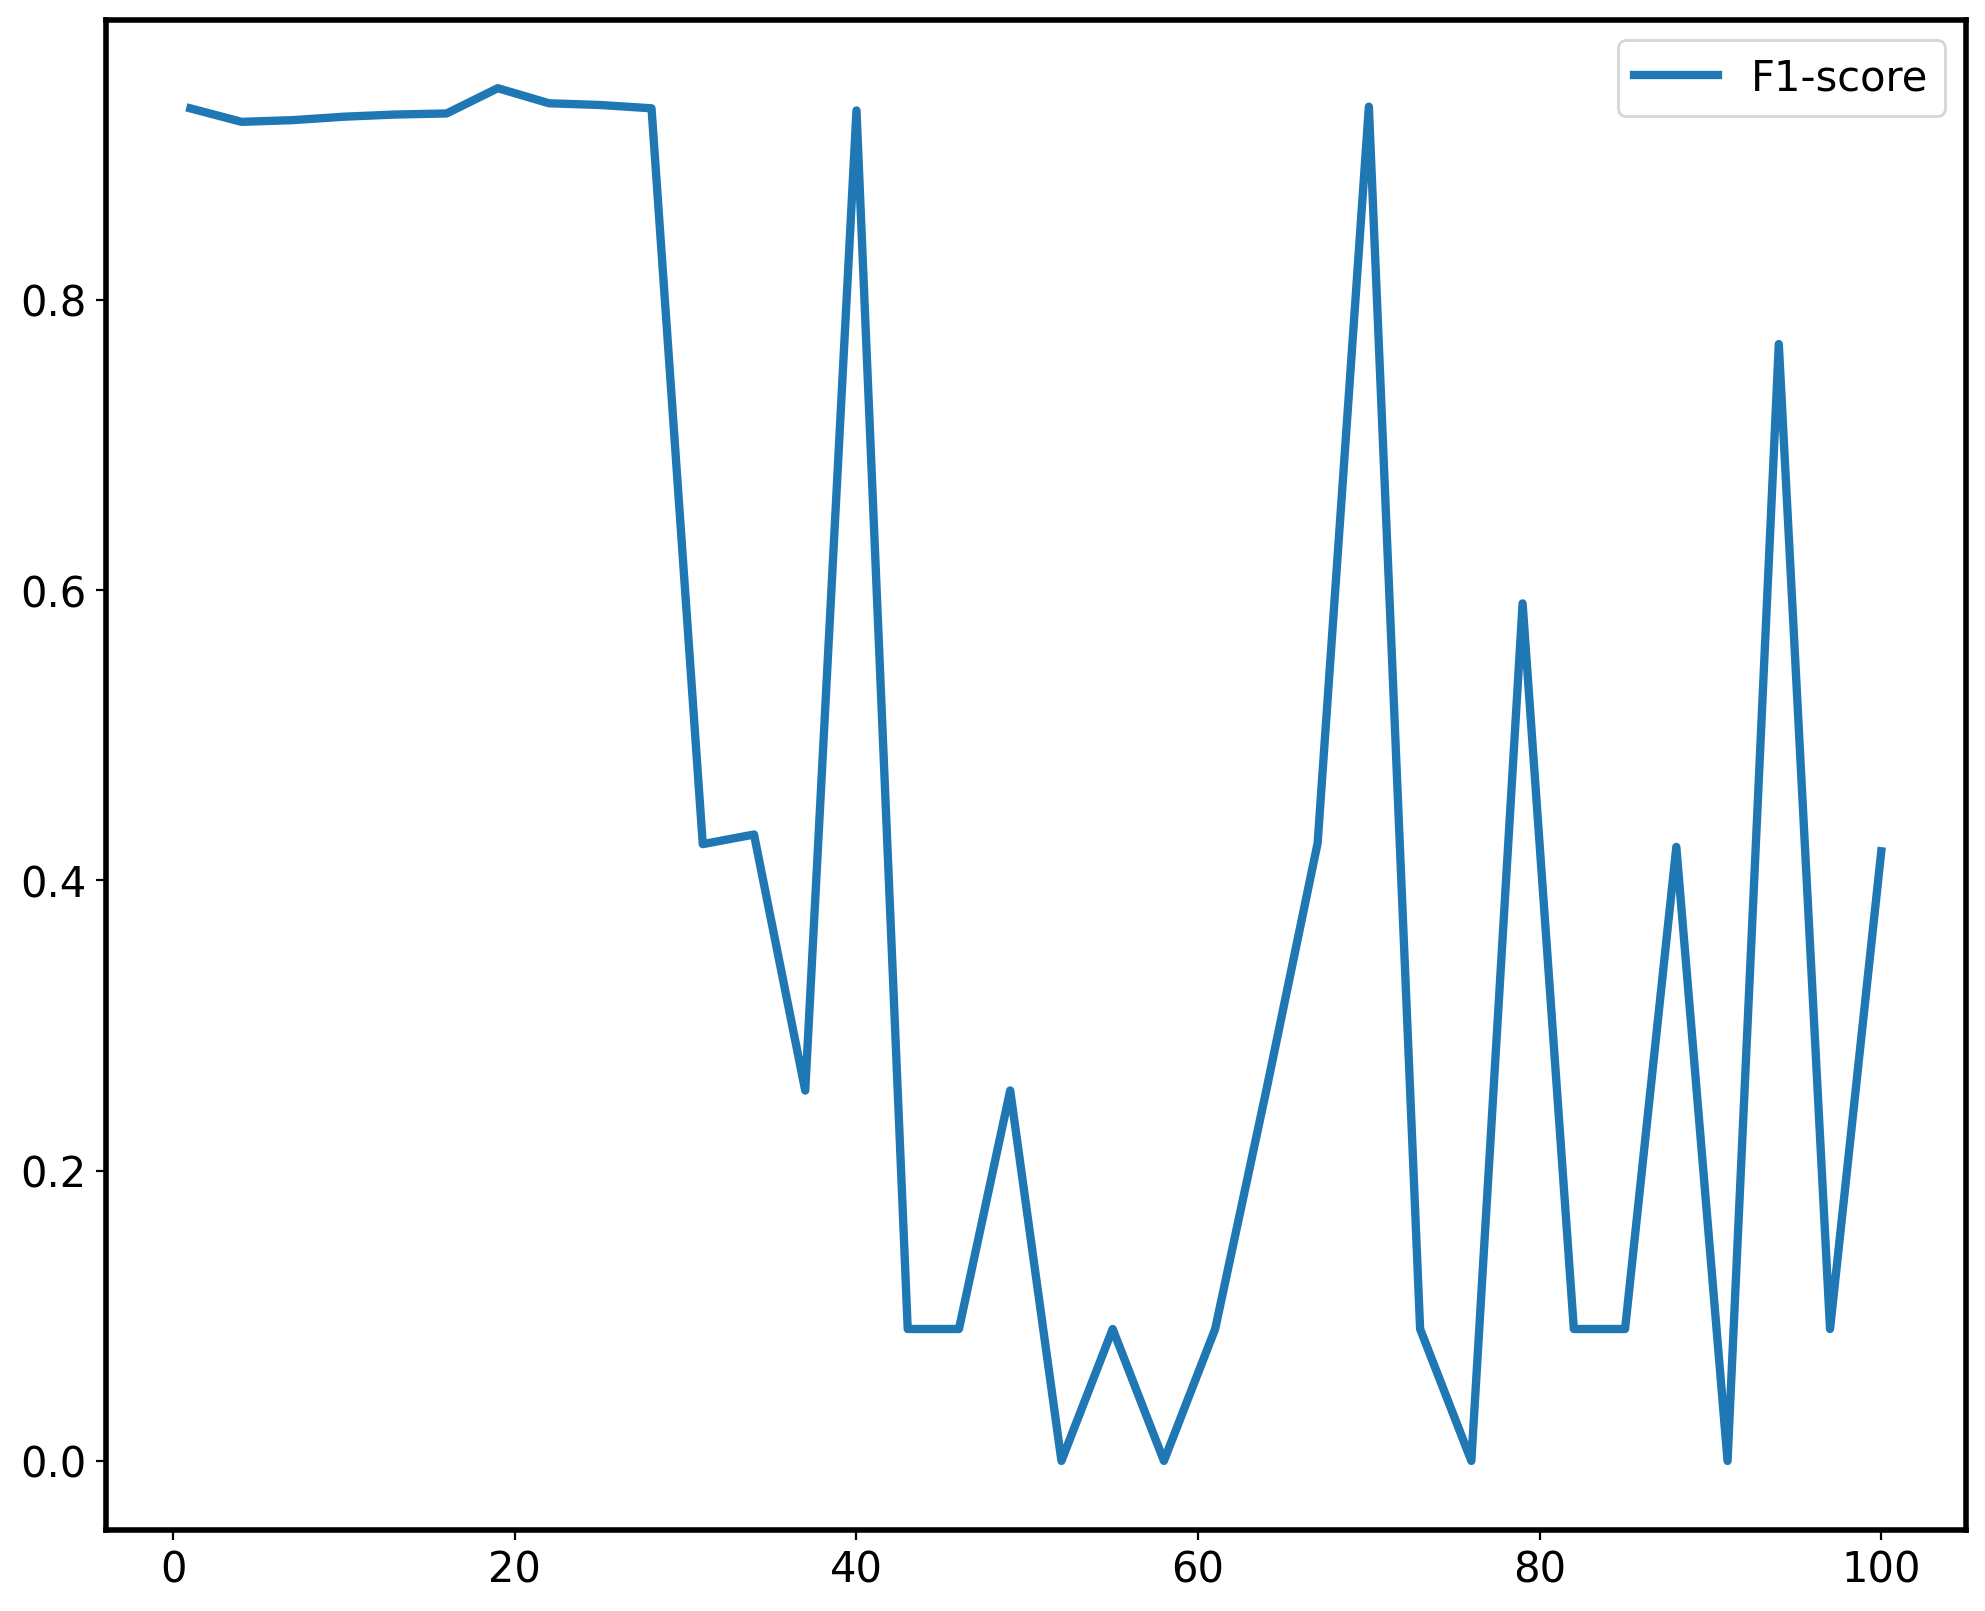

In [35]:
x = df['L']
y = df_f['fscore']

plt.figure(figsize=(12,10))
plt.plot(x,y,linewidth=3, label = 'F1-score')

# plt.ylim(0.6,0.65) # y축 값의 범위 설정
plt.legend()
plt.show()

In [36]:
df_f.to_csv("5CV_MLP_Card_L.csv", float_format='%.4g')

In [37]:
df = pd.read_csv("5CV_MLP_Card_L.csv")
df

,Unnamed: 0,L,fscore
0,0,1,0.93200
1,1,4,0.92270
2,2,7,0.92390
3,3,10,0.92630
4,4,13,0.92780
5,5,16,0.92850
6,6,19,0.94590
7,7,22,0.93550
8,8,25,0.93430
9,9,28,0.93210


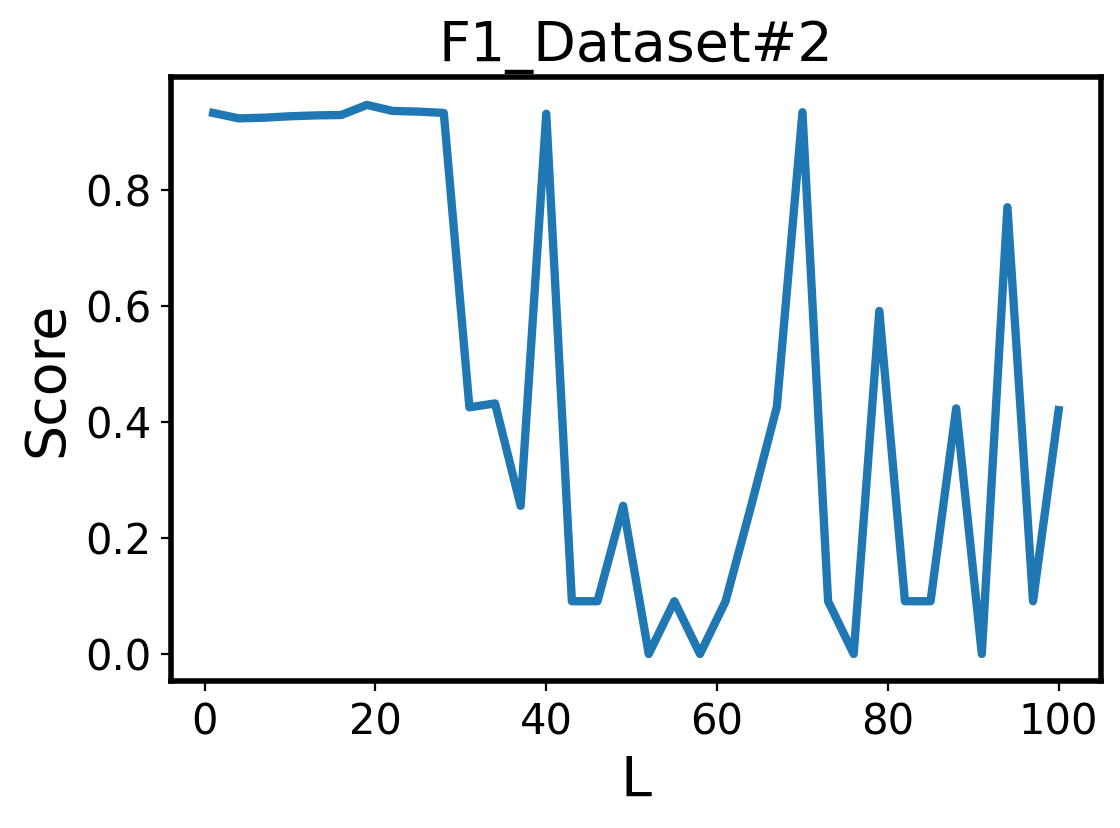

In [38]:
# plt.rcParams["figure.figsize"] = [5, 3]
plt.rcParams["figure.dpi"] = 200
plt.rcParams['axes.titlesize'] = 20  
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.labelsize'] = 20  
plt.rcParams['font.size'] = 15

x = df['L']
y = df['fscore']

plt.plot(x,y,linewidth=3, label = 'F1-score')

# plt.ylim(0.1,0.9) # y축 값의 범위 설정
plt.xlabel('L',fontsize = 20)
plt.ylabel('Score',fontsize = 20)
plt.title("F1_Dataset#2",fontsize = 20)
# plt.legend()
plt.show()

# 3. Breast Cancer Data (30d / 569)

In [39]:
# class 'B' = Benign, class 'M' = Malignant
cancer_df = pd.read_csv('breast_cancer.csv')
cancer_df.shape

(569, 32)

In [40]:
cancer_df.isnull().sum()

id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

In [41]:
cancer_df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [42]:
cancer_df.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [43]:
# M/Malignant = 0, B/Benign = 1
y_encoded, y_class = pd.factorize(cancer_df['diagnosis'])
print(y_class)
y_encoded

Index(['M', 'B'], dtype='object')


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,

In [44]:
# But I want [B/Benign = 0(Major), M/Malignant = 1(minor)]
y_encoded = (y_encoded+1)%2
y_encoded

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,

In [45]:
cancer_df['label'] = y_encoded
cancer_df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,label
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,1
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,1
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,1
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,1
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,1
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,1
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,1
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,1


In [46]:
cancer_df = cancer_df.drop('id', axis=1)
cancer_df = cancer_df.drop('diagnosis', axis=1)
cancer_df

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,label
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,1
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,1
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,1
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,1


In [47]:
# Amount values largely varies.

# # Normalization
# card_df.iloc[:,:-1] = (card_df.iloc[:,:-1] - card_df.iloc[:,:-1].min())/(card_df.iloc[:,:-1].max() - card_df.iloc[:,:-1].min())

# Standardization
cancer_df.iloc[:,:-1] = (cancer_df.iloc[:,:-1] - cancer_df.iloc[:,:-1].mean())/cancer_df.iloc[:,:-1].std()

cancer_df

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,label
0,1.096100,-2.071512,1.268817,0.983510,1.567087,3.280628,2.650542,2.530249,2.215566,2.253764,...,-1.358098,2.301575,1.999478,1.306537,2.614365,2.107672,2.294058,2.748204,1.935312,1
1,1.828212,-0.353322,1.684473,1.907030,-0.826235,-0.486643,-0.023825,0.547662,0.001391,-0.867889,...,-0.368879,1.533776,1.888827,-0.375282,-0.430066,-0.146620,1.086129,-0.243675,0.280943,1
2,1.578499,0.455786,1.565126,1.557513,0.941382,1.052000,1.362280,2.035440,0.938859,-0.397658,...,-0.023953,1.346291,1.455004,0.526944,1.081980,0.854222,1.953282,1.151242,0.201214,1
3,-0.768233,0.253509,-0.592166,-0.763792,3.280667,3.399917,1.914213,1.450431,2.864862,4.906602,...,0.133866,-0.249720,-0.549538,3.391291,3.889975,1.987839,2.173873,6.040726,4.930672,1
4,1.748758,-1.150804,1.775011,1.824624,0.280125,0.538866,1.369806,1.427237,-0.009552,-0.561956,...,-1.465481,1.337363,1.219651,0.220362,-0.313119,0.612640,0.728618,-0.867590,-0.396751,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,2.109139,0.720838,2.058974,2.341795,1.040926,0.218868,1.945573,2.318924,-0.312314,-0.930209,...,0.117596,1.751022,2.013529,0.378033,-0.273077,0.663928,1.627719,-1.358963,-0.708467,1
565,1.703356,2.083301,1.614511,1.722326,0.102368,-0.017817,0.692434,1.262558,-0.217473,-1.057681,...,2.045599,1.420690,1.493644,-0.690623,-0.394473,0.236365,0.733182,-0.531387,-0.973122,1
566,0.701667,2.043775,0.672084,0.577445,-0.839745,-0.038646,0.046547,0.105684,-0.808406,-0.894800,...,1.373645,0.578492,0.427529,-0.808876,0.350427,0.326479,0.413705,-1.103578,-0.318129,1
567,1.836725,2.334403,1.980781,1.733693,1.524426,3.269267,3.294046,2.656528,2.135315,1.042778,...,2.235958,2.301575,1.651717,1.429169,3.901415,3.194794,2.287972,1.917396,2.217684,1


In [48]:
cancer_df['label'].value_counts()

0    357
1    212
Name: label, dtype: int64

In [49]:
# Data is too balanced!!! We intentionally make it imbalanced.
df_0 = cancer_df[cancer_df['label']==0]
df_1 = cancer_df[cancer_df['label']==1]
print(len(df_0), len(df_1))

357 212


In [50]:
N = round(len(df_0)*0.1)
df_1_samp = df_1.sample(n=N, random_state = 100)
df_1_samp

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,label
219,1.533097,3.064460,1.482818,1.614345,-0.864631,0.163957,0.322388,0.449731,-1.399339,-1.369279,...,3.210535,2.170633,2.803894,0.369273,0.987914,0.610243,0.728618,-0.303481,-0.457654,1
45,1.283384,-0.392847,1.305856,1.196630,0.962713,1.216733,1.362280,1.339615,0.347926,-0.326840,...,-0.708923,1.289747,1.205600,1.556182,1.619046,2.216001,1.874173,1.451885,0.437632,1
408,1.096100,0.318610,1.063047,0.957083,0.514765,0.493423,0.392634,1.013350,0.657983,-0.298513,...,-0.043477,0.917752,0.822712,0.693374,0.757834,0.277588,1.259559,0.257396,0.060028,1
156,1.008133,0.337210,1.046586,0.877518,1.076478,1.176970,1.213007,1.455585,0.581381,-0.161126,...,-0.092288,0.763001,0.740163,0.413071,0.607202,0.412759,0.561273,-0.707570,-0.363530,1
213,0.934354,1.457870,0.927239,0.832905,0.301456,0.194253,0.995997,0.439423,-1.837067,-0.586034,...,0.389306,0.391006,0.246624,-0.353383,-0.476463,0.038881,-0.071597,-2.097638,-0.872908,1
100,-0.146789,1.323019,-0.161284,-0.205133,-0.105252,-0.364135,-0.031978,-0.103836,-0.739099,-0.578952,...,1.560751,0.039842,0.045520,-0.257029,-0.381126,0.214316,0.057716,-0.403695,-0.552332,1
372,2.055224,-0.974102,2.030166,2.077526,0.265905,0.892947,1.309595,1.973589,0.588676,-0.137048,...,-0.624319,1.334387,1.149396,-0.576750,0.188990,0.624144,1.247389,-0.276002,0.150276,1
212,3.967796,-0.190570,3.972634,5.240230,1.268455,0.894841,2.901420,2.849813,-0.596837,-1.069012,...,-1.172620,2.417638,2.842534,-0.795736,-0.652519,0.229655,0.682979,-2.024902,-1.588804,1
433,1.331624,0.623187,1.305856,1.293244,0.386780,0.654369,0.885610,0.992733,0.479244,-0.209282,...,0.854630,1.132021,1.268829,0.290438,0.584956,0.570459,0.854888,0.171729,-0.044616,1
365,1.791323,0.579012,1.721511,1.813257,-0.345580,0.165850,0.115287,0.745586,-0.706269,-1.023688,...,0.112715,1.605200,1.579706,0.014515,-0.105920,-0.009531,0.941603,-0.471582,-0.918862,1


In [51]:
cancer_df = concath(df_0, df_1_samp)
cancer_df

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,label
19,-0.166653,-1.146154,-0.185565,-0.251735,0.101657,-0.436466,-0.277965,-0.028584,0.267676,-0.727669,...,-1.044086,-0.225019,-0.297499,0.509425,-0.489175,-0.159083,0.215933,0.123238,-0.628739,0
20,-0.297184,-0.832276,-0.260877,-0.383301,0.792066,0.429044,-0.540886,-0.459223,0.566790,0.752425,...,-0.843964,-0.332451,-0.439238,-0.051181,0.148312,-0.398748,-0.635551,0.457824,-0.117147,0
21,-1.311926,-1.592558,-1.301661,-1.082620,0.429441,-0.746429,-0.743094,-0.725698,0.012334,0.885562,...,-1.629809,-1.253810,-0.993547,0.001375,-0.886413,-0.879660,-0.796202,-0.728583,-0.344152,0
37,-0.311372,-0.202195,-0.385162,-0.372503,-0.464322,-1.262592,-0.792517,-0.507415,-1.257077,-0.590283,...,-0.466499,-0.678556,-0.587827,-1.548613,-1.322484,-1.073022,-0.980890,-1.476957,-1.232240,0
46,-1.683090,-0.569549,-1.656820,-1.287215,-0.736646,-0.850381,-0.914695,-1.108221,-0.155461,0.316186,...,-0.604795,-1.488019,-1.121235,-0.116877,-0.753576,-0.974903,-1.353462,0.330132,-0.545688,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,0.117112,1.918224,0.195933,0.011113,1.247125,1.044426,0.942058,0.637089,1.792428,1.129176,...,1.863374,0.501116,0.109978,1.551802,2.564154,2.063094,0.860973,2.129139,2.776892,1
489,0.727206,0.211659,0.622700,0.576024,-1.520911,-0.629033,-0.656165,-0.666166,0.125414,-1.352283,...,0.143628,0.596347,0.357275,-1.378241,0.239836,-0.117381,-0.414350,2.871047,-0.427202,1
451,1.550123,1.327669,1.470472,1.523414,0.486324,-0.106622,0.962128,1.074943,-0.542121,-1.258804,...,0.859511,0.968343,0.949171,0.894842,-0.443413,0.601615,0.486728,-0.982351,-1.275426,1
223,0.460467,0.223284,0.437507,0.302377,0.436552,0.304075,0.324896,0.404632,0.450062,0.032915,...,0.750502,0.554684,0.364300,0.999955,1.231342,0.601136,0.506505,1.765458,1.243223,1


In [52]:
cancer_df['label'].value_counts()

0    357
1     36
Name: label, dtype: int64

In [53]:
L = 73
hidden_node = 2
# momentum=0.9
activation = 'sigmoid'  
kernel_initializer=keras.initializers.he_normal(seed=100)
epochs=50
threshold = 0.5

In [54]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state = 2)

fscore = []

X = cancer_df.iloc[:, :-1]
y = cancer_df.iloc[:, -1]

for i in range(34):
    print('!'*50,'L={0}'.format(3*i+1),'!'*50)
    L = 3*i + 1
    f1 = []
    batch_size = int(X.shape[0]*0.9 * 0.05)  
    learning_rate = 0.01
    model = Sequential()
    model.add(Dense(hidden_node, input_dim=X.shape[1], kernel_initializer=kernel_initializer))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dense(1))
    opt = optimizers.Adam(learning_rate = learning_rate)   # SGD(learning_rate=learning_rate, momentum=momentum)
    
    n_iter=0
    for train_index, test_index in skf.split(X, y):
        n_iter += 1
        X_train = X.iloc[train_index]
        y_train= y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test= y.iloc[test_index]
    #     print('#'*50,'{0}th CV'.format(n_iter),'#'*50)
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        y_train = y_train.astype(float)
        X_test = np.array(X_test)
        y_test = np.array(y_test)
        y_test = y_test.astype(float)

        ###################### Ours(F1) ##############################  
        beta = 1
        model.compile(loss=Ours_Fbeta, optimizer=opt, metrics=['accuracy'])
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0, batch_size=batch_size)
#         plt.plot(history.history['loss'], label='loss')
#         plt.ylim([0, 1])
#         plt.xlabel('Iteration',fontweight="bold",fontsize = 15)
#         plt.ylabel('Loss',fontweight="bold",fontsize = 15)
#         plt.title("Cost Function",fontweight="bold",fontsize = 20)
#         plt.legend()
#         plt.show()
        predicted = []
        result = model.predict(X_test)
        for i in range(X_test.shape[0]):
            if result[i] <= threshold:
                predicted.append(0)
            else:
                predicted.append(1)
        TN = metrics.confusion_matrix(y_test, predicted)[0,0]
        FP = metrics.confusion_matrix(y_test, predicted)[0,1]
        FN = metrics.confusion_matrix(y_test, predicted)[1,0]
        TP = metrics.confusion_matrix(y_test, predicted)[1,1]
        f1.append(TP / (TP + 0.5*(FP+FN)))

    print('F1 =', np.mean(f1), f1)
    fscore.append(np.mean(f1))

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! L=1 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
3/3 [==============================] - 0s 790us/step
F1 = 0.9167365967365967 [1.0, 0.7272727272727273, 0.9333333333333333, 1.0, 0.9230769230769231]
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! L=4 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
3/3 [==============================] - 0s 903us/step
F1 = 0.9227106227106228 [1.0, 0.8333333333333334, 0.8571428571428571, 1.0, 0.9230769230769231]
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! L=7 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
3/3 [==============================] - 0s 929us/step
F1 = 0.956043956043956 [1.0, 0.9230769230769231, 0.8571428571428571, 1.0, 1.0]
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! L=10 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
3/3 [==============================] - 0s 926us/step
F1 = 0.9187878787878787 [1.0, 0.7272727272727273, 0.9333333333333333, 0.9333333333333333, 1.0]

3/3 [==============================] - 0s 875us/step
F1 = 0.9442307692307693 [1.0, 0.9230769230769231, 0.875, 1.0, 0.9230769230769231]
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! L=49 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
3/3 [==============================] - 0s 875us/step
F1 = 0.9712820512820514 [1.0, 0.9230769230769231, 0.9333333333333333, 1.0, 1.0]
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! L=52 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
3/3 [==============================] - 0s 868us/step
F1 = 0.16778024120634621 [0.16279069767441862, 0.16279069767441862, 0.1839080459770115, 0.16470588235294117, 0.16470588235294117]
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! L=55 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
3/3 [==============================] - 0s 875us/step
F1 = 0.16778024120634621 [0.16279069767441862, 0.16279069767441862, 0.1839080459770115, 0.16470588235294117, 0.16470588235294117]
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

3/3 [==============================] - 0s 908us/step
F1 = 0.16778024120634621 [0.16279069767441862, 0.16279069767441862, 0.1839080459770115, 0.16470588235294117, 0.16470588235294117]
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! L=100 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
3/3 [==============================] - 0s 885us/step
F1 = 0.16778024120634621 [0.16279069767441862, 0.16279069767441862, 0.1839080459770115, 0.16470588235294117, 0.16470588235294117]


In [55]:
df_f = pd.DataFrame({'L':list(np.arange(1, 101, 3)), 'fscore':fscore})
df_f

,L,fscore
0,1,0.916737
1,4,0.922711
2,7,0.956044
3,10,0.918788
4,13,0.937949
5,16,0.946282
6,19,0.984615
7,22,0.937949
8,25,0.942711
9,28,0.942711


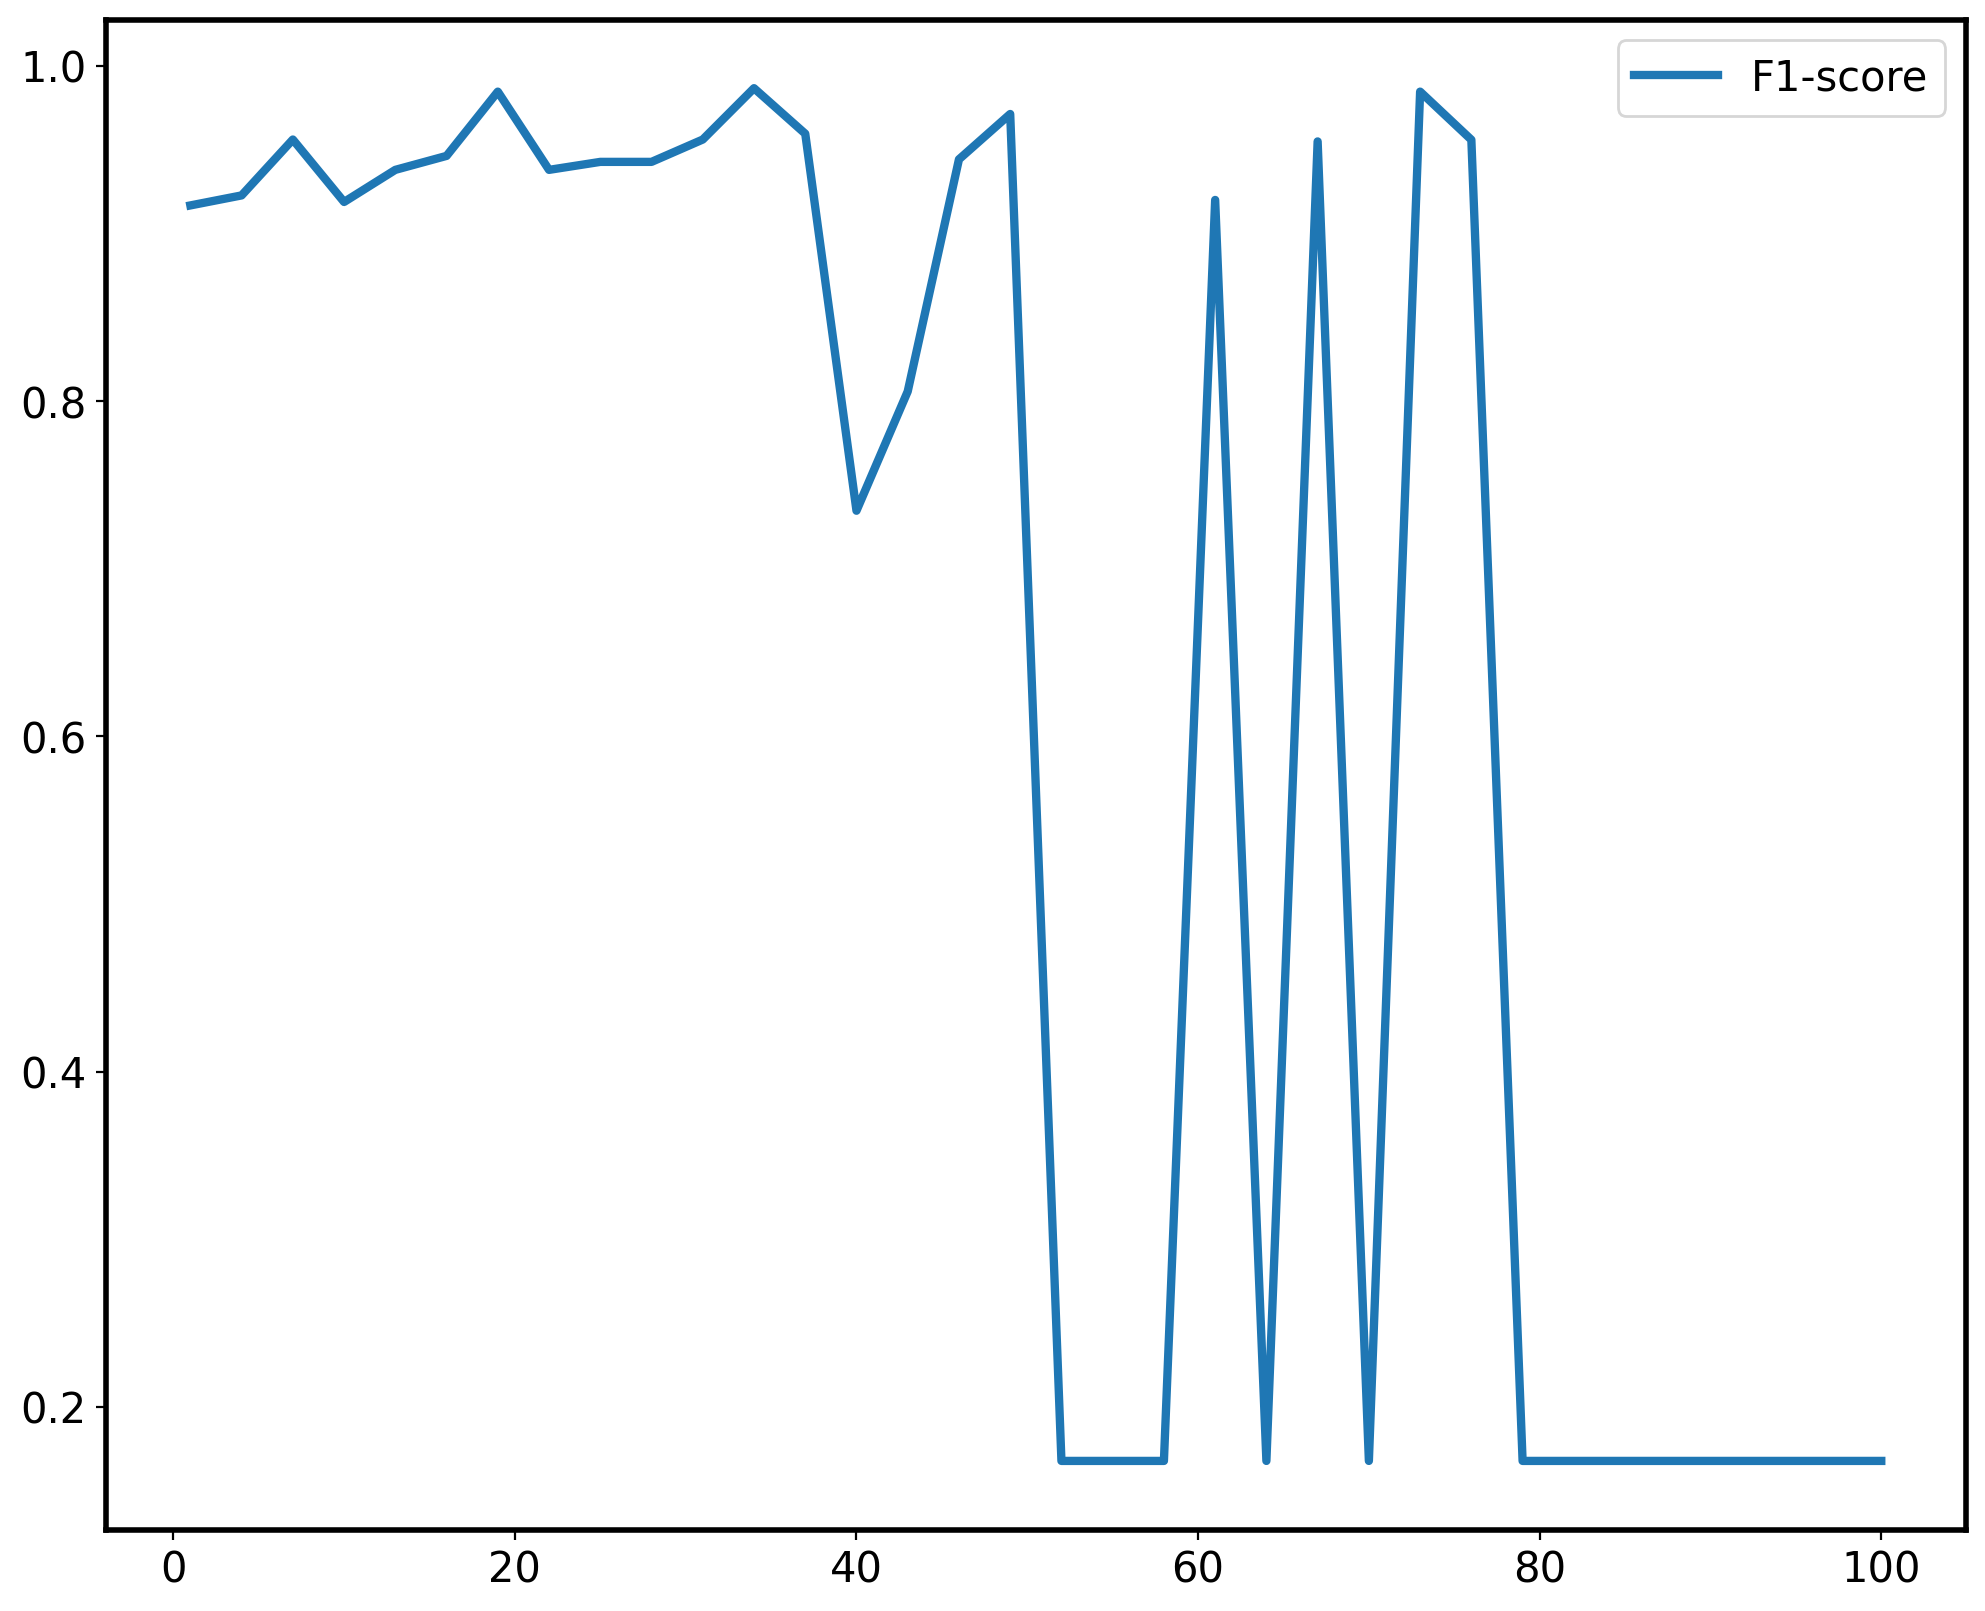

In [56]:
x = df['L']
y = df_f['fscore']

plt.figure(figsize=(12,10))
plt.plot(x,y,linewidth=3, label = 'F1-score')

# plt.ylim(0.6,0.65) # y축 값의 범위 설정
plt.legend()
plt.show()

In [57]:
df_f.to_csv("5CV_MLP_Cancer_L.csv", float_format='%.4g')

In [58]:
df = pd.read_csv("5CV_MLP_Cancer_L.csv")
df

,Unnamed: 0,L,fscore
0,0,1,0.9167
1,1,4,0.9227
2,2,7,0.9560
3,3,10,0.9188
4,4,13,0.9379
5,5,16,0.9463
6,6,19,0.9846
7,7,22,0.9379
8,8,25,0.9427
9,9,28,0.9427


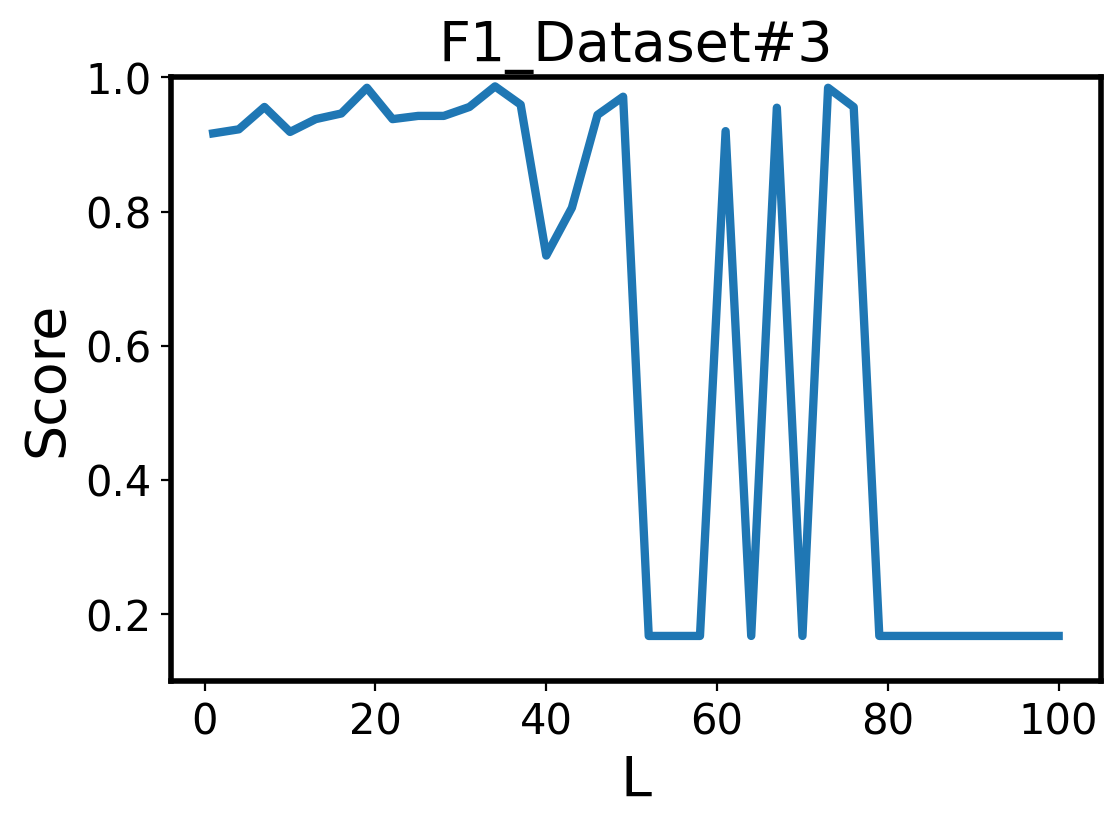

In [59]:
# plt.rcParams["figure.figsize"] = [5, 3]
plt.rcParams["figure.dpi"] = 200
plt.rcParams['axes.titlesize'] = 20  
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.labelsize'] = 20  
plt.rcParams['font.size'] = 15

x = df['L']
y = df['fscore']

plt.plot(x,y,linewidth=3, label = 'F1-score')

plt.ylim(0.1,1.0) # y축 값의 범위 설정
plt.xlabel('L',fontsize = 20)
plt.ylabel('Score',fontsize = 20)
plt.title("F1_Dataset#3",fontsize = 20)
# plt.legend()
plt.show()

# 4. Diabetes Prediction Data (8d / 100000)

In [60]:
# class 'B' = Benign, class 'M' = Malignant
diab_df = pd.read_csv('diabetes_prediction_dataset.csv')
diab_df.shape

(100000, 9)

In [61]:
diab_df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [62]:
diab_df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


In [63]:
# Female = 0, Male = 1, other = 2
gen_encoded, gen_class = pd.factorize(diab_df['gender'])
print(gen_class)
gen_encoded

Index(['Female', 'Male', 'Other'], dtype='object')


array([0, 0, 1, ..., 1, 0, 0])

In [64]:
# Female = 0, Male = 1, other = 2
pd.Series(gen_encoded).value_counts()

0    58552
1    41430
2       18
dtype: int64

In [65]:
diab_df['gender'] = gen_encoded
diab_df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,80.0,0,1,never,25.19,6.6,140,0
1,0,54.0,0,0,No Info,27.32,6.6,80,0
2,1,28.0,0,0,never,27.32,5.7,158,0
3,0,36.0,0,0,current,23.45,5.0,155,0
4,1,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,0,80.0,0,0,No Info,27.32,6.2,90,0
99996,0,2.0,0,0,No Info,17.37,6.5,100,0
99997,1,66.0,0,0,former,27.83,5.7,155,0
99998,0,24.0,0,0,never,35.42,4.0,100,0


In [66]:
# never = 0, Info = 1, current = 2, former=3, ever=4, not current=5
smo_encoded, smo_class = pd.factorize(diab_df['smoking_history'])
print(smo_class)
smo_encoded

Index(['never', 'No Info', 'current', 'former', 'ever', 'not current'], dtype='object')


array([0, 1, 0, ..., 3, 0, 2])

In [67]:
# never = 0, Info = 1, current = 2, former=3, ever=4, not current=5
pd.Series(smo_encoded).value_counts()

1    35816
0    35095
3     9352
2     9286
5     6447
4     4004
dtype: int64

In [68]:
diab_df['smoking_history'] = smo_encoded
diab_df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,80.0,0,1,0,25.19,6.6,140,0
1,0,54.0,0,0,1,27.32,6.6,80,0
2,1,28.0,0,0,0,27.32,5.7,158,0
3,0,36.0,0,0,2,23.45,5.0,155,0
4,1,76.0,1,1,2,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,0,80.0,0,0,1,27.32,6.2,90,0
99996,0,2.0,0,0,1,17.37,6.5,100,0
99997,1,66.0,0,0,3,27.83,5.7,155,0
99998,0,24.0,0,0,0,35.42,4.0,100,0


In [69]:
diab_df.describe()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.414660,41.885856,0.07485,0.039420,1.306950,27.320767,5.527507,138.058060,0.085000
std,0.493031,22.516840,0.26315,0.194593,1.454501,6.636783,1.070672,40.708136,0.278883
min,0.000000,0.080000,0.00000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,0.000000,24.000000,0.00000,0.000000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,0.000000,43.000000,0.00000,0.000000,1.000000,27.320000,5.800000,140.000000,0.000000
75%,1.000000,60.000000,0.00000,0.000000,2.000000,29.580000,6.200000,159.000000,0.000000
max,2.000000,80.000000,1.00000,1.000000,5.000000,95.690000,9.000000,300.000000,1.000000


In [70]:
# Amount values largely varies.

# # Normalization
# card_df.iloc[:,:-1] = (card_df.iloc[:,:-1] - card_df.iloc[:,:-1].min())/(card_df.iloc[:,:-1].max() - card_df.iloc[:,:-1].min())

# Standardization
diab_df.iloc[:,:-1] = (diab_df.iloc[:,:-1] - diab_df.iloc[:,:-1].mean())/diab_df.iloc[:,:-1].std()

diab_df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,-0.841043,1.692695,-0.284438,4.936354,-0.898556,-0.321054,1.001701,0.047704,0
1,-0.841043,0.538004,-0.284438,-0.202577,-0.211035,-0.000116,1.001701,-1.426203,0
2,1.187228,-0.616688,-0.284438,-0.202577,-0.898556,-0.000116,0.161107,0.489876,0
3,-0.841043,-0.261398,-0.284438,-0.202577,0.476486,-0.583229,-0.492688,0.416181,0
4,1.187228,1.515050,3.515669,4.936354,0.476486,-1.081965,-0.679486,0.416181,0
...,...,...,...,...,...,...,...,...,...
99995,-0.841043,1.692695,-0.284438,-0.202577,-0.211035,-0.000116,0.628104,-1.180552,0
99996,-0.841043,-1.771379,-0.284438,-0.202577,-0.211035,-1.499336,0.908301,-0.934901,0
99997,1.187228,1.070938,-0.284438,-0.202577,1.164008,0.076729,0.161107,0.416181,0
99998,-0.841043,-0.794332,-0.284438,-0.202577,-0.898556,1.220355,-1.426681,-0.934901,0


In [71]:
L = 73
hidden_node = 2
# momentum=0.9
activation = 'sigmoid'  
kernel_initializer=keras.initializers.he_normal(seed=100)
epochs=50
threshold = 0.5

In [73]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state = 2)

fscore = []

X = diab_df.iloc[:, :-1]
y = diab_df.iloc[:, -1]

for i in range(34):
    print('!'*50,'L={0}'.format(3*i+1),'!'*50)
    L = 3*i + 1
    f1 = []
    batch_size = int(X.shape[0]*0.9 * 0.05)  
    learning_rate = 0.003
    model = Sequential()
    model.add(Dense(hidden_node, input_dim=X.shape[1], kernel_initializer=kernel_initializer))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dense(1))
    opt = optimizers.Adam(learning_rate = learning_rate)   # SGD(learning_rate=learning_rate, momentum=momentum)
    
    n_iter=0
    for train_index, test_index in skf.split(X, y):
        n_iter += 1
        X_train = X.iloc[train_index]
        y_train= y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test= y.iloc[test_index]
    #     print('#'*50,'{0}th CV'.format(n_iter),'#'*50)
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        y_train = y_train.astype(float)
        X_test = np.array(X_test)
        y_test = np.array(y_test)
        y_test = y_test.astype(float)

        ###################### Ours(F1) ##############################  
        beta = 1
        model.compile(loss=Ours_Fbeta, optimizer=opt, metrics=['accuracy'])
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0, batch_size=batch_size)
#         plt.plot(history.history['loss'], label='loss')
#         plt.ylim([0, 1])
#         plt.xlabel('Iteration',fontweight="bold",fontsize = 15)
#         plt.ylabel('Loss',fontweight="bold",fontsize = 15)
#         plt.title("Cost Function",fontweight="bold",fontsize = 20)
#         plt.legend()
#         plt.show()
        predicted = []
        result = model.predict(X_test)
        for i in range(X_test.shape[0]):
            if result[i] <= threshold:
                predicted.append(0)
            else:
                predicted.append(1)
        TN = metrics.confusion_matrix(y_test, predicted)[0,0]
        FP = metrics.confusion_matrix(y_test, predicted)[0,1]
        FN = metrics.confusion_matrix(y_test, predicted)[1,0]
        TP = metrics.confusion_matrix(y_test, predicted)[1,1]
        f1.append(TP / (TP + 0.5*(FP+FN)))

    print('F1 =', np.mean(f1), f1)
    fscore.append(np.mean(f1))

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! L=1 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
625/625 [==============================] - 0s 420us/step
F1 = 0.7302990175790651 [0.7226415094339622, 0.7333333333333333, 0.7345430107526881, 0.7330814153211954, 0.7278958190541467]
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! L=4 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
625/625 [==============================] - 0s 438us/step
F1 = 0.7282559434758593 [0.7190542420027817, 0.7268877911079746, 0.7313585291113381, 0.7352342158859471, 0.728744939271255]
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! L=7 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
625/625 [==============================] - 0s 433us/step
F1 = 0.7292950253276839 [0.7201401050788091, 0.7282913165266106, 0.7332878581173261, 0.7350720658888126, 0.7296837810268616]
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! L=10 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
625/625 [=====================

625/625 [==============================] - 0s 433us/step
F1 = 0.5023945726571556 [0.7222414389484607, 0.7414435784479837, 0.7349237905897945, 0.15668202764976957, 0.15668202764976957]
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! L=52 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
625/625 [==============================] - 0s 434us/step
F1 = 0.15668202764976957 [0.15668202764976957, 0.15668202764976957, 0.15668202764976957, 0.15668202764976957, 0.15668202764976957]
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! L=55 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
625/625 [==============================] - 0s 448us/step
F1 = 0.6178206221420017 [0.7277091906721537, 0.7385864051403449, 0.7342192691029901, 0.7319062181447502, 0.15668202764976957]
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! L=58 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
625/625 [==============================] - 0s 431us/step
F1 = 0.5019649528338315 [0.7296108291032148, 0.7351425626932325, 0.

In [74]:
df_f = pd.DataFrame({'L':list(np.arange(1, 101, 3)), 'fscore':fscore})
df_f

,L,fscore
0,1,0.730299
1,4,0.728256
2,7,0.729295
3,10,0.730142
4,13,0.729276
5,16,0.156682
6,19,0.731508
7,22,0.156682
8,25,0.732813
9,28,0.731249


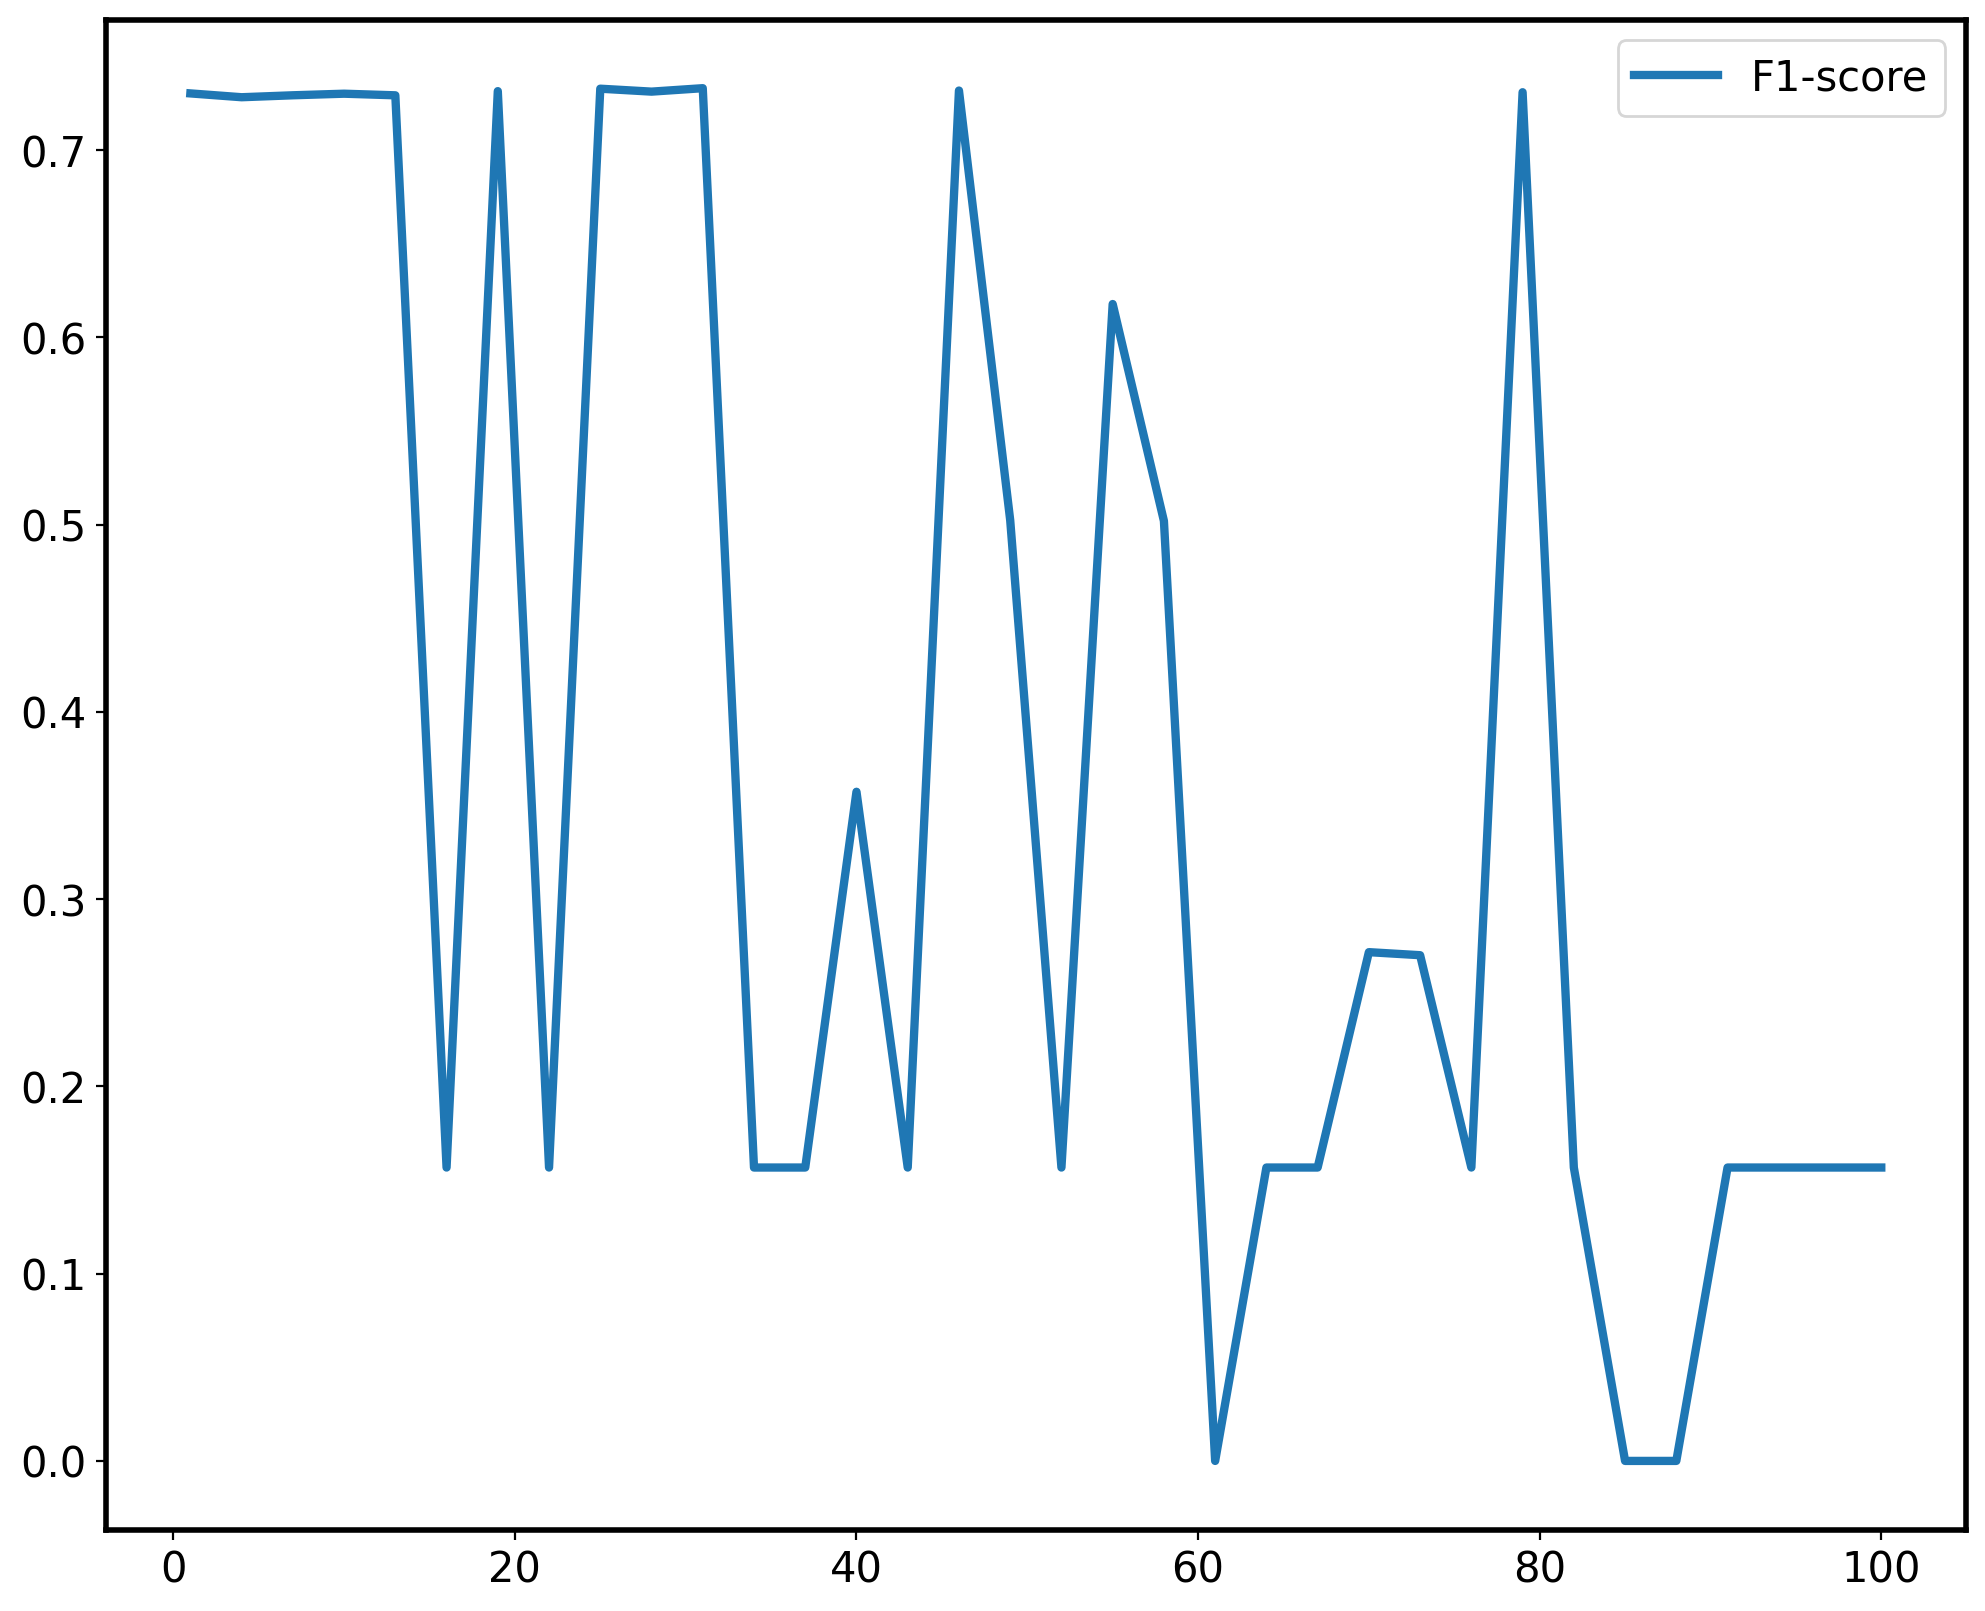

In [75]:
x = df['L']
y = df_f['fscore']

plt.figure(figsize=(12,10))
plt.plot(x,y,linewidth=3, label = 'F1-score')

# plt.ylim(0.6,0.65) # y축 값의 범위 설정
plt.legend()
plt.show()

In [76]:
df_f.to_csv("5CV_MLP_Diab_L.csv", float_format='%.4g')

In [77]:
df = pd.read_csv("5CV_MLP_Diab_L.csv")
df

,Unnamed: 0,L,fscore
0,0,1,0.7303
1,1,4,0.7283
2,2,7,0.7293
3,3,10,0.7301
4,4,13,0.7293
5,5,16,0.1567
6,6,19,0.7315
7,7,22,0.1567
8,8,25,0.7328
9,9,28,0.7312


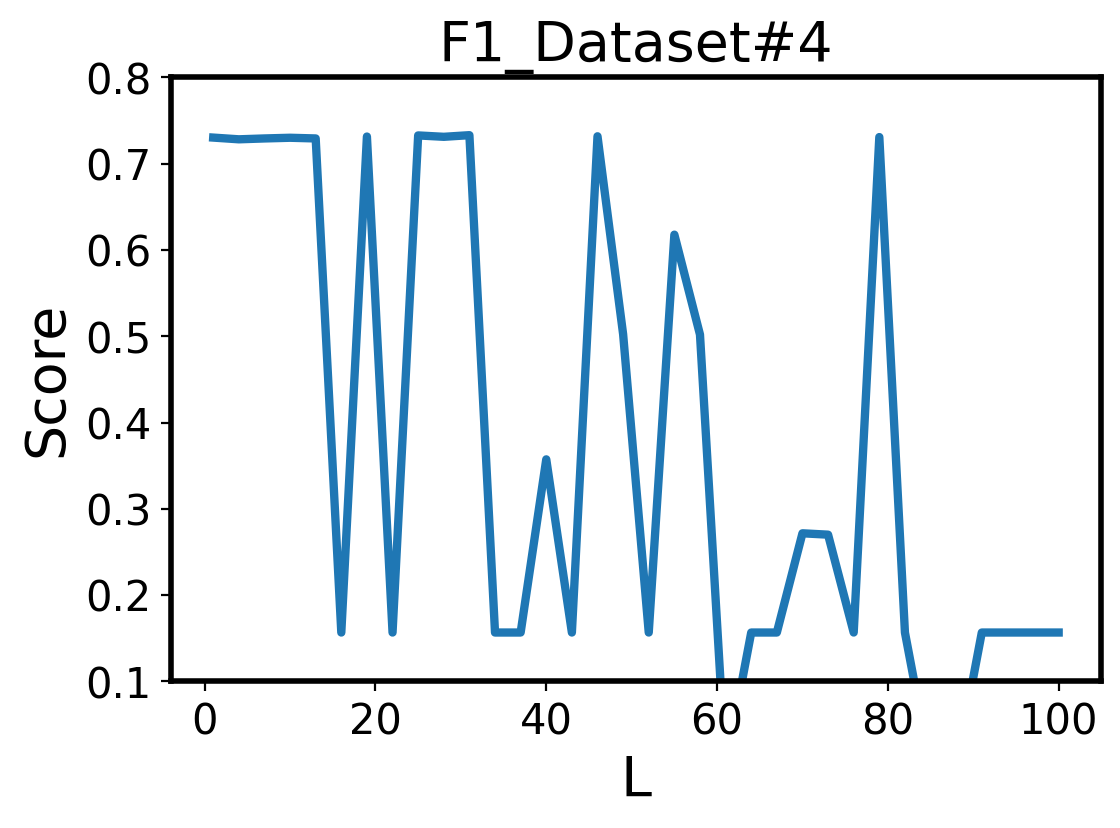

In [78]:
# plt.rcParams["figure.figsize"] = [5, 3]
plt.rcParams["figure.dpi"] = 200
plt.rcParams['axes.titlesize'] = 20  
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.labelsize'] = 20  
plt.rcParams['font.size'] = 15

x = df['L']
y = df['fscore']

plt.plot(x,y,linewidth=3, label = 'F1-score')

plt.ylim(0.1,0.8) # y축 값의 범위 설정
plt.xlabel('L',fontsize = 20)
plt.ylabel('Score',fontsize = 20)
plt.title("F1_Dataset#4",fontsize = 20)
# plt.legend()
plt.show()